# Topic Evaluation & Exploration

Evaluate topic assignment to Posts.

In [1]:
import os, sys, ast
sys.path.append("..")
from config import credentials
import dropbox

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23

## Loading

In [3]:
team_dbx = dropbox.DropboxTeam(credentials.dropbox_team_access_token)
team_root = team_dbx.with_path_root(dropbox.common.PathRoot.namespace_id(
    credentials.dropbox_team_namespace_id))
user_dbx = team_root.as_user(credentials.dropbox_team_member_id)

In [4]:
data_path = "/Data/CSVData"
model_path = "../models"
figures_path = "../reports/figures/"

In [5]:
topics40_fpath = os.path.join(data_path, "topics", "topics.csv")
_, res = user_dbx.files_download(topics40_fpath)
topics40 = pd.read_csv(res.raw)

posts_fpath = os.path.join(data_path, "PolPosts.csv")
_, res = user_dbx.files_download(posts_fpath)
posts = pd.read_csv(res.raw)

print("Topics n40", topics40.shape)
print("All Posts", posts.shape)

Topics n40 (22534, 4)
All Posts (27204, 23)


In [6]:
topic_interpretation = {0: "-", 1: "Wahlwerbung & Dank", 2: "Linke Themen",
                        3: "-", 4: "-", 5: "FPÖ", 6: "Wandel (Partei)",
                        7: "Anti-Rechts", 8: "-", 9: "Extrem Links", 10: "Liberal",
                        11: "-", 12: "-", 13: "Mobilisierung Wien", 14: "ORF Wahldebatte",
                        15: "Mobilisierung Länder", 16: "-",
                        17: "Puls4 Wahldebatte", 18: "Emotionen", 19: "Außenpolitik",
                        20: "Wahlprognose", 21: "Umwelt", 22: "-", 23: "-", 24: "-",
                        25: "Polarisierung", 26: "Strache", 27: "-",
                        28: "-", 29: "Neos", 30: "-", 31: "-",
                        32: "-", 33: "-", 34: "-", 35: "Greta Thunberg",
                        36: "-", 37: "-", 38: "-", 39: "-"}

## Exploration

### Posts per topic

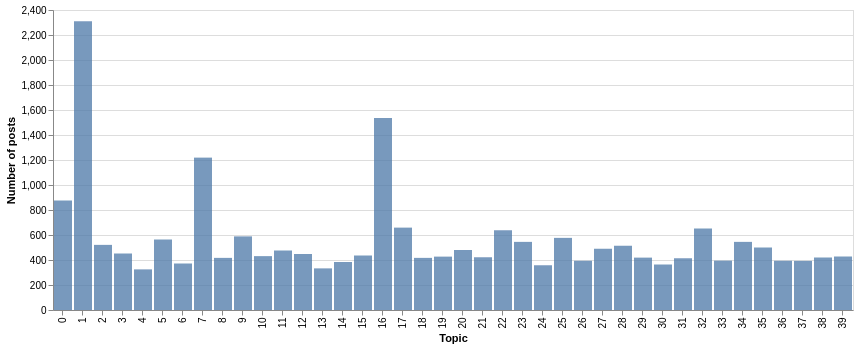

In [8]:
p_data = topics40.topic.value_counts().to_frame("count").rename_axis("topic").reset_index()
p_data["Topic"] = p_data.topic.map(topic_interpretation)

chart = alt.Chart(p_data).mark_bar().encode(
    x=alt.X("topic:N", title="Topic"),
    y=alt.Y("count:Q", title="Number of posts"),
    opacity=alt.value(0.75),
    tooltip=["Topic"]
)

#chart.save(os.path.join(figures_path, "topics", "posts_per_topic.html"))
chart

Top-10 Posts per Topic

In [9]:
def get_top_10(df, topic, topic_range):
    topic_subset = df[df.topic == topic].copy()
    topic_subset.topic_distribution = topic_subset.topic_distribution.apply(ast.literal_eval)
    flattend_subset = pd.concat([topic_subset,
                                 pd.DataFrame(topic_subset.topic_distribution.values.tolist(),
                                              index=topic_subset.index, columns=topic_range)],
                                axis=1)
    return flattend_subset.sort_values(by=[topic], ascending=False).text.head(10)

In [10]:
topics40_top10_fp = "../reports/topics_40_top-10.txt"
topic_range = range(0, 40)

# with open(topics40_top10_fp, "w") as f:
#     for i in topic_range:
#         with pd.option_context("display.max_colwidth", -1):
#             f.write("Topic " + str(i) + ":\n" + get_top_10(topics40, i, topic_range).to_string(index=False) + "\n\n")

### Interactions per topic

In [11]:
data = posts.set_index("textID").join(topics40.set_index("textID"), lsuffix="_posts", rsuffix="_topics")
data.dropna(subset=["text_posts", "topic"], inplace=True)
data.drop_duplicates(subset=["text_posts"], keep="first", inplace=True)
data.topic = data.topic.apply(int)
data["topic_interpretation"] = data.topic.map(topic_interpretation)
data["source"] = data.Site

Total interactions

In [12]:
grouped = data.groupby(["topic", "topic_interpretation"]).agg({"interactionCount": ["count", "sum", "mean"]})
pd.set_option("display.max_rows", None)
grouped

interactionCount                    
                                      count     sum        mean
topic topic_interpretation                                     
0     -                                 876  180549  206.106164
1     Wahlwerbung & Dank               2310  879202  380.606926
2     Linke Themen                      521  142128  272.798464
3     -                                 452   62064  137.309735
4     -                                 325   79746  245.372308
5     FPÖ                               564  130939  232.161348
6     Wandel (Partei)                   372   87524  235.279570
7     Anti-Rechts                      1219  221796  181.949139
8     -                                 417  133800  320.863309
9     Extrem Links                      589  128693  218.494058
10    Liberal                           431   63386  147.067285
11    -                                 476  115553  242.758403
12    -                                 448  199774  445.924107
13    Mobilisierung Wien                333   55743  167.396396
14    ORF Wahldebatte                   384   88074  229.359375
15    Mobilisierung Länder              436   78303  179.594037
16    -                                1536  169019  110.038411
17    Puls4 Wahldebatte                 659  121036  183.666161
18    Emotionen                         417   92149  220.980815
19    Außenpolitik                      427   77720  182.014052
20    Wahlprognose                      480  204100  425.208333
21    Umwelt                            422  131814  312.355450
22    -                                 638   95210  149.231975
23    -                                 545   76939  141.172477
24    -                                 358  256212  715.675978
25    Polarisierung                     577   93081  161.318891
26    Strache                           394   66361  168.428934
27    -                                 490  106738  217.832653
28    -                                 514  440199  856.418288
29    Neos                              419   68540  163.579952
30    -                                 364   58367  160.348901
31    -                                 414   63435  153.224638
32    -                                 652  156245  239.639571
33    -                                 395   68136  172.496203
34    -                                 545  139781  256.478899
35    Greta Thunberg                    500  116562  233.124000
36    -                                 394  100688  255.553299
37    -                                 393  184696  469.964377
38    -                                 420  152524  363.152381
39    -                                 428  188490  440.397196

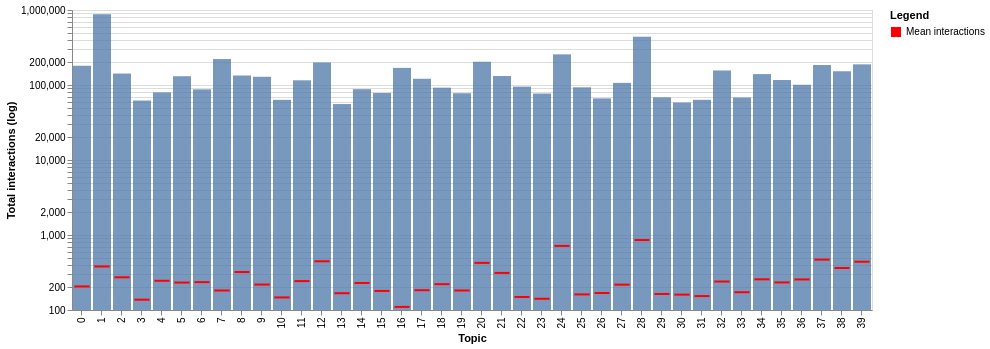

In [13]:
grouped.columns = ["count", "sum", "mean"]
p_data = grouped.reset_index()
p_data["Topic"] = p_data.topic_interpretation
p_data["bar_label"] = ["Total interactions"] * p_data.shape[0]
p_data["mean_label"] = ["Mean interactions"] * p_data.shape[0]

bars = alt.Chart(p_data).mark_bar().encode(
    x=alt.X("topic:N", title="Topic"),
    y=alt.Y("sum:Q",
            scale=alt.Scale(type="log", base=10),
            title="Total interactions (log)"),
    opacity=alt.value(0.75),
    tooltip=["Topic"]
)

mean_ticks = alt.Chart(p_data).mark_tick(color="red", thickness=2).encode(
    x=alt.X("topic:N", title="Topic"),
    y=alt.Y("mean:Q",
            scale=alt.Scale(type="log", base=10),
            title=""),
    color=alt.Color("mean_label",
                    scale=alt.Scale(range=["red"], domain=["Mean interactions"]), 
                    title="Legend"),
    opacity=alt.value(1)
)

chart = bars + mean_ticks
#chart.save(os.path.join(figures_path, "topics", "interactions_per_topic.html"))
chart

Interactions per source

In [14]:
grouped = data.groupby(["topic", "topic_interpretation", "source"]).agg({"interactionCount": ["count", "sum", "mean"]})
pd.set_option("display.max_rows", None)
grouped

interactionCount                     
                                               count     sum         mean
topic topic_interpretation source                                        
0     -                    Facebook              301  105855   351.677741
                           Twitter               575   74694   129.902609
1     Wahlwerbung & Dank   Facebook             1403  824235   587.480399
                           Twitter               907   54967    60.603087
2     Linke Themen         Facebook              263   61623   234.307985
                           Twitter               258   80505   312.034884
3     -                    Facebook              242   50335   207.995868
                           Twitter               210   11729    55.852381
4     -                    Facebook              181   42462   234.596685
                           Twitter               144   37284   258.916667
5     FPÖ                  Facebook              324   99072   305.777778
                           Twitter               240   31867   132.779167
6     Wandel (Partei)      Facebook              226   41681   184.429204
                           Twitter               146   45843   313.993151
7     Anti-Rechts          Facebook              617  191025   309.602917
                           Twitter               602   30771    51.114618
8     -                    Facebook              234   64165   274.209402
                           Twitter               183   69635   380.519126
9     Extrem Links         Facebook              315   50675   160.873016
                           Twitter               274   78018   284.737226
10    Liberal              Facebook              217   47967   221.046083
                           Twitter               214   15419    72.051402
11    -                    Facebook              250   53497   213.988000
                           Twitter               226   62056   274.584071
12    -                    Facebook              247   47753   193.331984
                           Twitter               201  152021   756.323383
13    Mobilisierung Wien   Facebook              178   38099   214.039326
                           Twitter               155   17644   113.832258
14    ORF Wahldebatte      Facebook              209   76634   366.669856
                           Twitter               175   11440    65.371429
15    Mobilisierung Länder Facebook              242   60577   250.318182
                           Twitter               194   17726    91.371134
16    -                    Facebook              529  136111   257.298677
                           Twitter              1007   32908    32.679245
17    Puls4 Wahldebatte    Facebook              387  108018   279.116279
                           Twitter               272   13018    47.860294
18    Emotionen            Facebook              215   52106   242.353488
                           Twitter               202   40043   198.232673
19    Außenpolitik         Facebook              214   52967   247.509346
                           Twitter               213   24753   116.211268
20    Wahlprognose         Facebook              209   31662   151.492823
                           Twitter               271  172438   636.302583
21    Umwelt               Facebook              219   49558   226.292237
                           Twitter               203   82256   405.201970
22    -                    Facebook              300   73039   243.463333
                           Twitter               338   22171    65.594675
23    -                    Facebook              312   64745   207.516026
                           Twitter               233   12194    52.334764
24    -                    Facebook              184   41925   227.853261
                           Twitter               174  214287  1231.534483
25    Polarisierung        Facebook              299   75002   250.842809
                           Twitter      

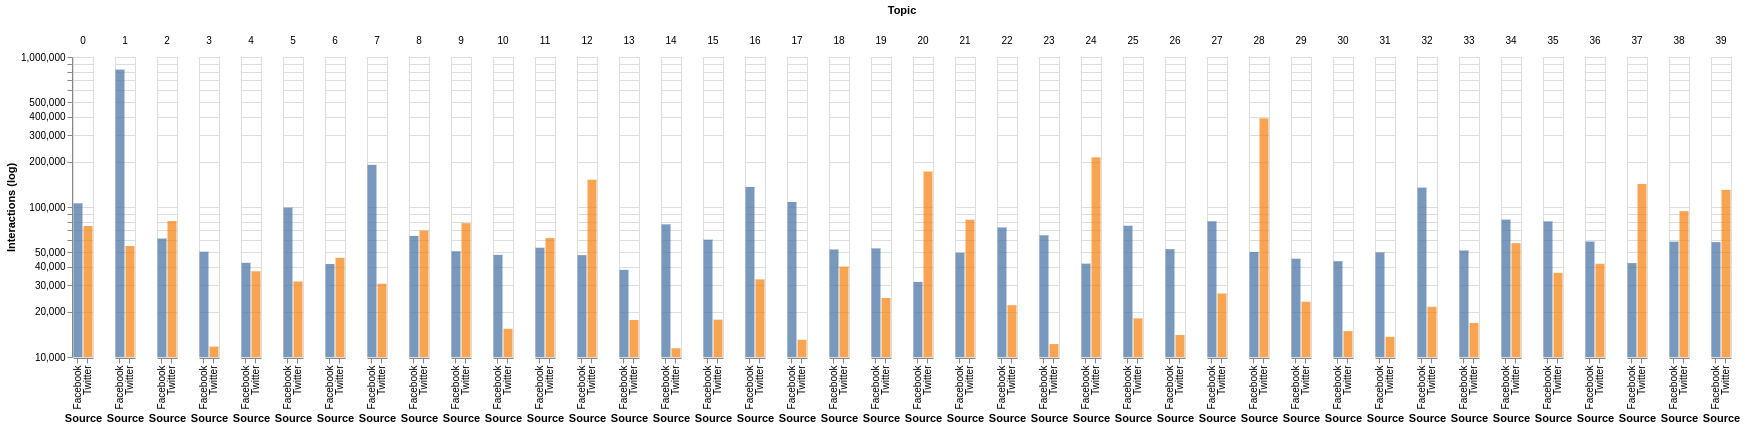

In [15]:
p_data = grouped.copy()
p_data["source"] = p_data.index.get_level_values("source")
p_data.columns = ["count", "sum", "mean", "Source"]
p_data.reset_index(inplace=True)
p_data["Topic"] = p_data.topic_interpretation

chart = alt.Chart(p_data).mark_bar().encode(
    alt.X("Source:N"),
    alt.Y("sum(sum):Q", 
          scale=alt.Scale(type="log", base=10),
          title="Interactions (log)"),
    column=alt.Column("topic:O", title="Topic"),
    color=alt.Color("Source", legend=None),
    opacity=alt.value(0.75),
    tooltip=["Topic"]
).properties(
    width=20
)

#chart.save(os.path.join(figures_path, "topics", "interactions_per_source.html"))
chart

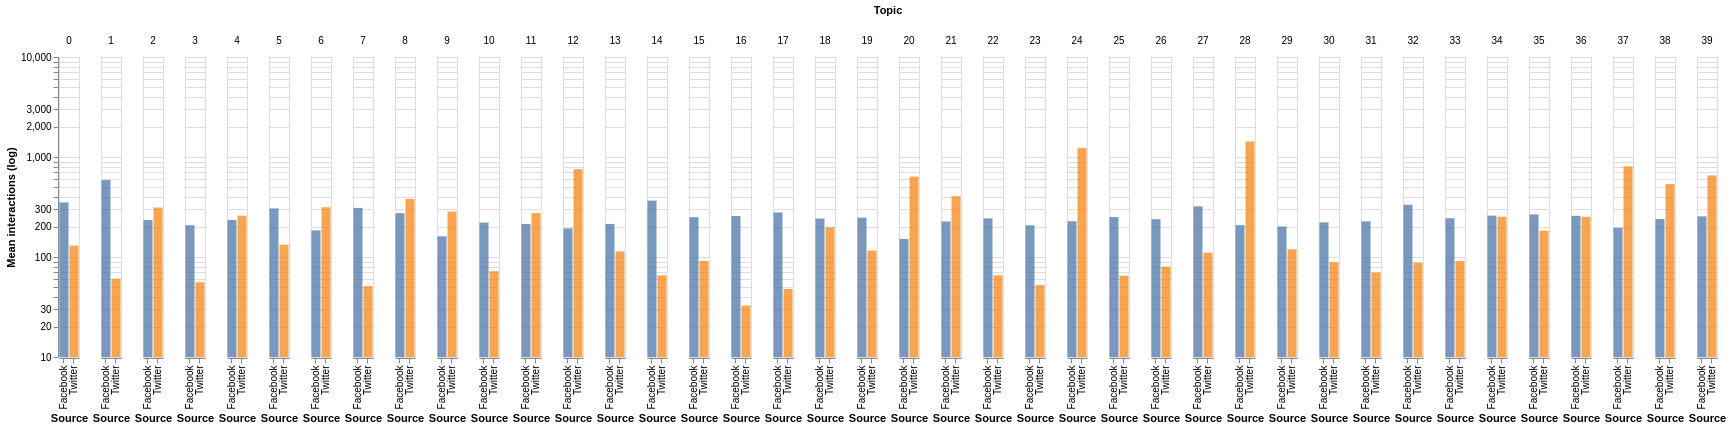

In [16]:
p_data = grouped.copy()
p_data["source"] = p_data.index.get_level_values("source")
p_data.columns = ["count", "sum", "mean", "Source"]
p_data.reset_index(inplace=True)
p_data["Topic"] = p_data.topic_interpretation

chart = alt.Chart(p_data).mark_bar().encode(
    alt.X("Source:N"),
    alt.Y("sum(mean):Q", 
          scale=alt.Scale(type="log", base=10),
          title="Mean interactions (log)"),
    column=alt.Column("topic:O", title="Topic"),
    color=alt.Color("Source", legend=None),
    opacity=alt.value(0.75),
    tooltip=["Topic"]
).properties(
    width=20
)

#chart.save(os.path.join(figures_path, "topics", "mean_interactions_per_source.html"))
chart